##### This follower model is tailored to the input file of 34 bus system in per unit (input format to be used which includes all imputs required to run the network model as well). Additional constraint for reactive power is considered.

In [12]:
from pyomo.environ import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use({'figure.facecolor':'white'})

In [13]:
def data_viz(model, d_i):
    Pdt = pd.DataFrame()
    price = pd.DataFrame()
    energy = pd.DataFrame()
    Pdmt = pd.DataFrame()
    Pdmt_max = pd.DataFrame()
    util = pd.DataFrame()
    # 12 is the number of blocks
    blocks_m = ['d'+str(i+1) for i in range(174)]

    for t in model.TIME:
        for a in model.AGG:
            if a == d_i:
                Pdt.loc[t,'Consumption'] = model.Pdt[a,t].value
        price.loc[t, 'Price'] = model.ct[t].value
        for m in blocks_m:
                for a,m_u,t_u in model.UTILS:
                    if a == d_i and t_u == t and m_u == m:
                        Pdmt.loc[t,m] = model.Pdmt[a,m,t].value
                        Pdmt_max.loc[t,m] = model.PblockMax[a,m,t].value
                        util.loc[t,m] = model.util[a,m,t].value
    for a in model.AGG:
        if a == d_i:
            energy.loc[a, 'Energy'] = model.Einflex[a]

    energy_tot = np.cumsum(Pdt)

    fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
    ax[0,0].plot(Pdt.index, energy_tot, linestyle='--', marker='o', alpha=0.6, label='$E_{cum}$');
    ax[0,0].fill_between(Pdt.index, energy_tot['Consumption'], np.zeros(len(energy_tot)), alpha=0.6)
    ax[0,0].plot(Pdt.index, Pdt, marker='o', label='$P_{'+str(d_i)+',t}$');ax[0,0].set_xlabel('Time [h]');ax[0,0].set_ylabel('Active Power [kW]');ax[0,0].set_title('Agg '+str(d_i)+' Consumption');
    ax[0,0].hlines(energy['Energy'], Pdt.index[0], Pdt.index[-1], colors='red', label='$E_{min}$')
    ax[0,0].legend(bbox_to_anchor=(0.1,0.7), loc='center', borderaxespad=0)
    ax[0,1].plot(price.index, price, marker='o');ax[0,1].set_xlabel('Time [h]');ax[0,1].set_ylabel('Price [$]');ax[0,1].set_title('Price');
    util.plot(ax=ax[1,0], kind='bar', alpha=1, rot=0, edgecolor='white', linewidth=1);ax[1,0].set_xlabel('Time [h]');ax[1,0].set_ylabel('Utility [$/kWh]');ax[1,0].set_title('Utility Blocks');
    Pdmt_max.plot(ax=ax[1,1], kind='bar', alpha=1, rot=0, edgecolor='white', linewidth=1, legend=None);ax[1,1].set_xlabel('Time [h]');ax[1,1].set_ylabel('Active Power [kW]');ax[1,1].set_title('Flexibility');
    Pdmt.plot(ax=ax[1,1], kind='bar', alpha=1, rot=0, edgecolor='black', linewidth=1, hatch='/');
    fig.tight_layout()
    fig.show;
    plt.savefig('aggregator_'+str(d_i)+'.png', bbox_inches='tight')

In [14]:
def read_input(filename):
    NodeData = pd.read_excel(filename, sheet_name='NodeData')
    SystemDemand = pd.read_excel(filename, sheet_name='SystemDemand')
    AggData = pd.read_excel(filename, sheet_name='AggData')
    DemandBlocks = pd.read_excel(filename, sheet_name='DemandBlocks')
    UtilTimeMul = pd.read_excel(filename, sheet_name='UtilTimeMul')

    return {'SystemDemand':SystemDemand, 'NodeData':NodeData, 'AggData':AggData, 'DemandBlocks':DemandBlocks, 'UtilTimeMul':UtilTimeMul}

In [15]:
#data = read_input(r'Input_Files\Aggregator.xlsx')
data = read_input(r'Input_Files\InputDataVreeswajk_v2_1d.xlsx')

<ipython-input-13-9e2aad5bd1d5>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))


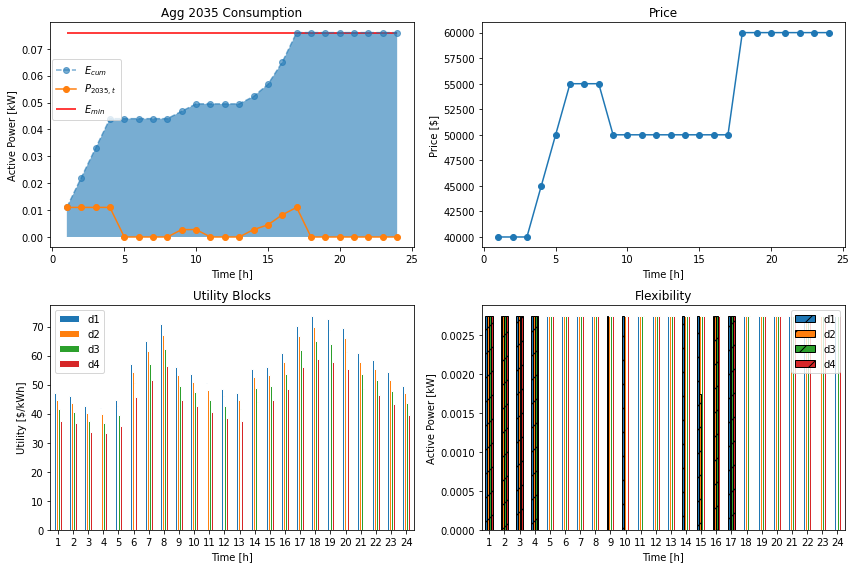

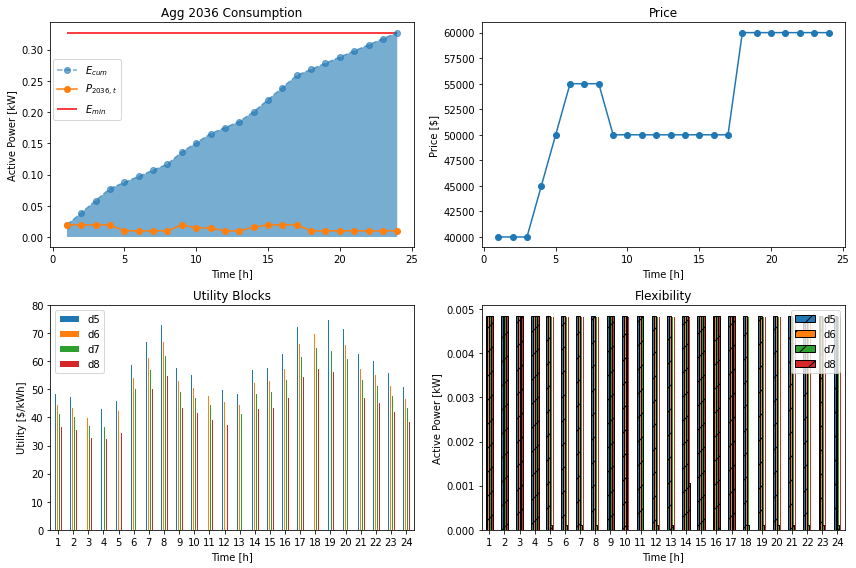

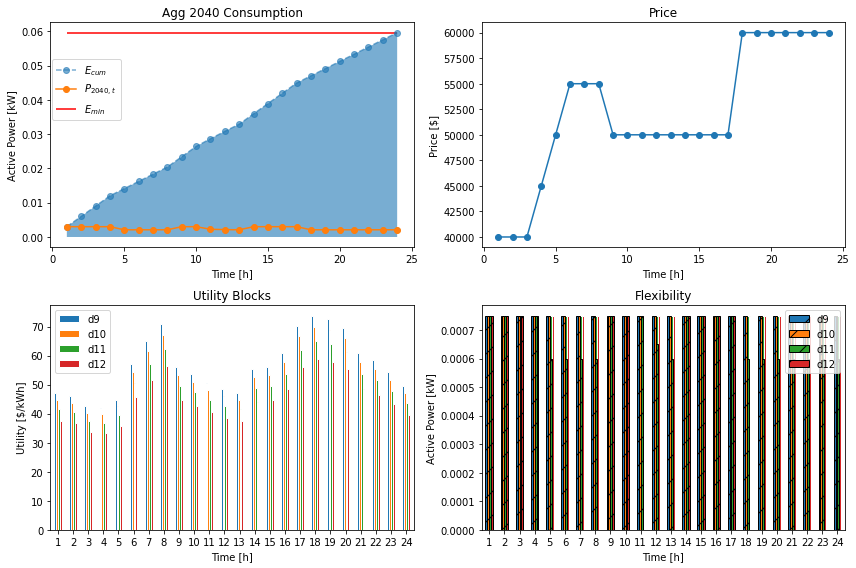

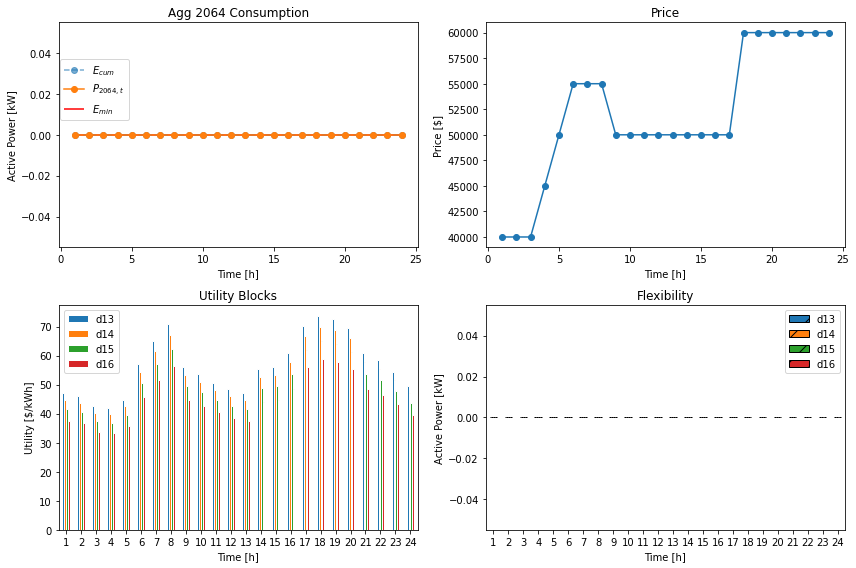

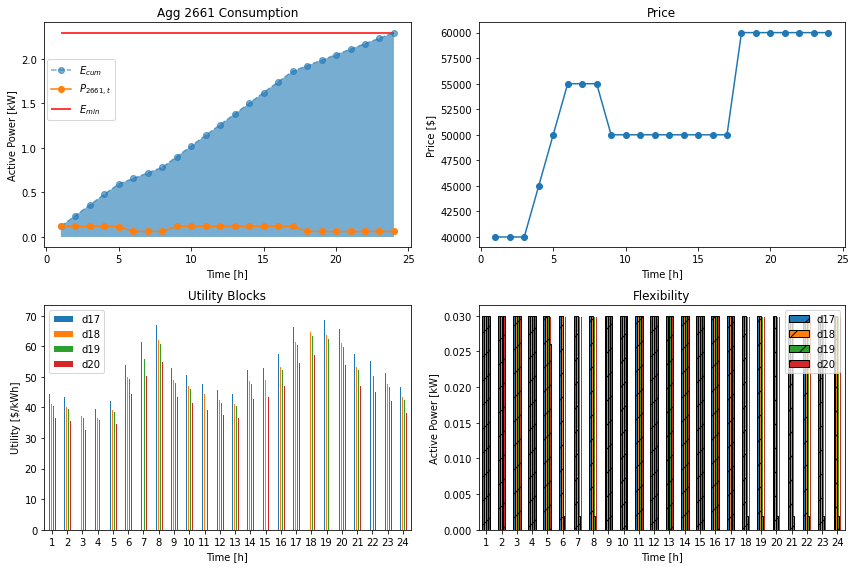

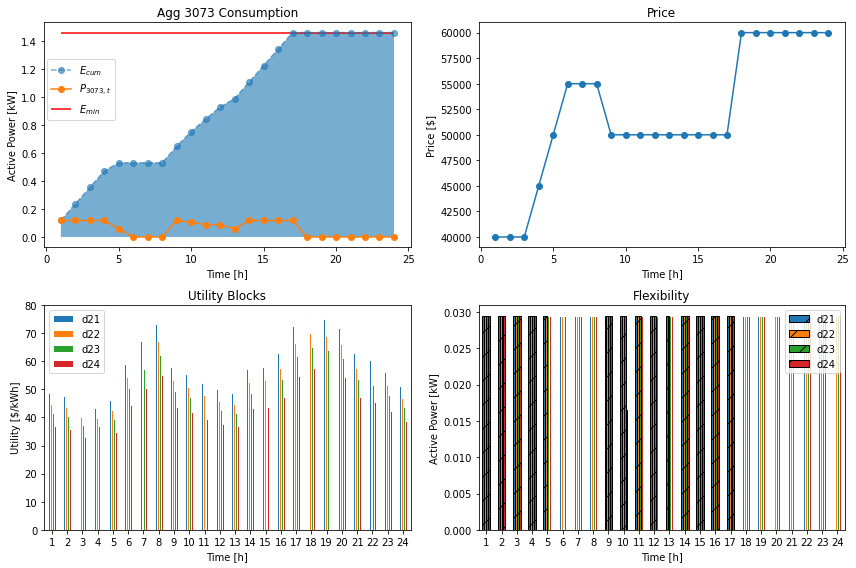

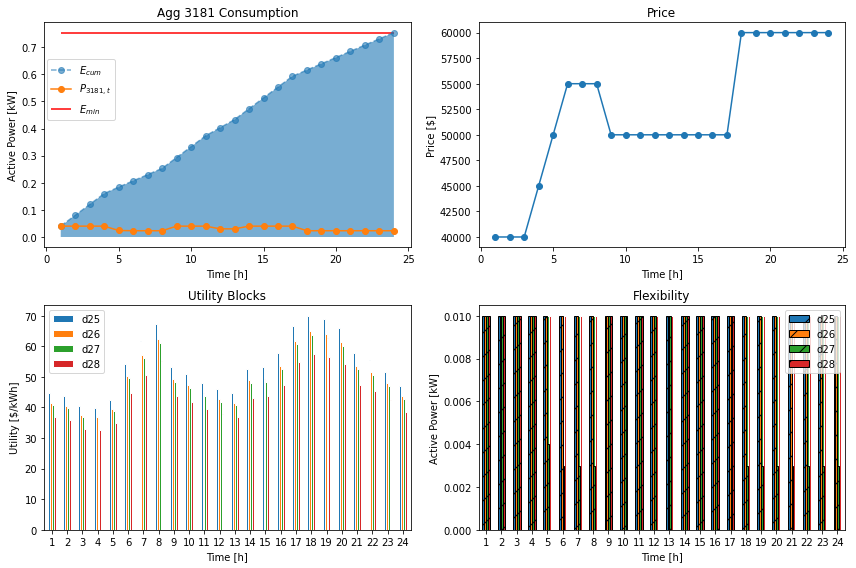

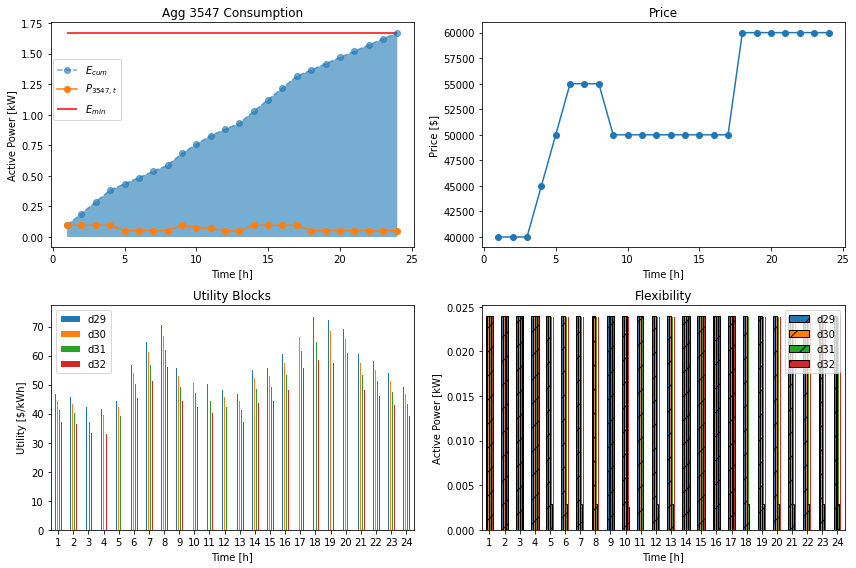

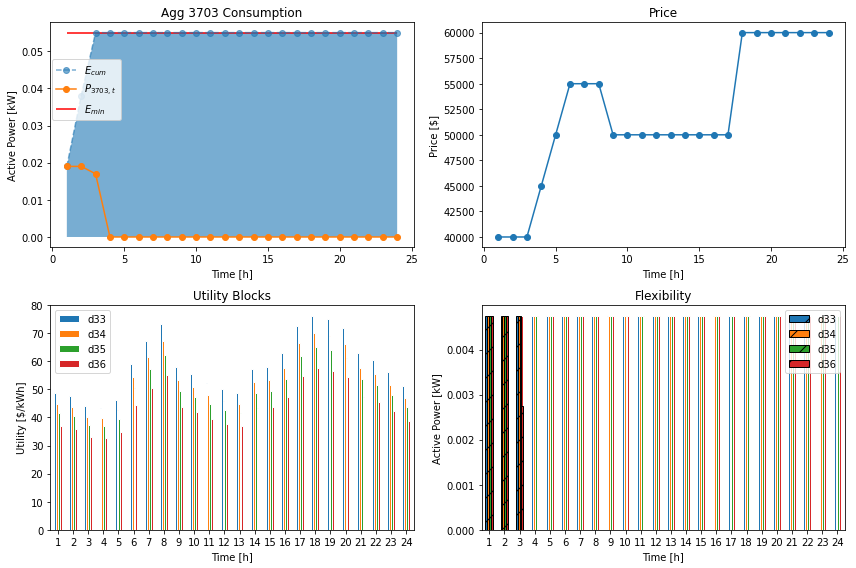

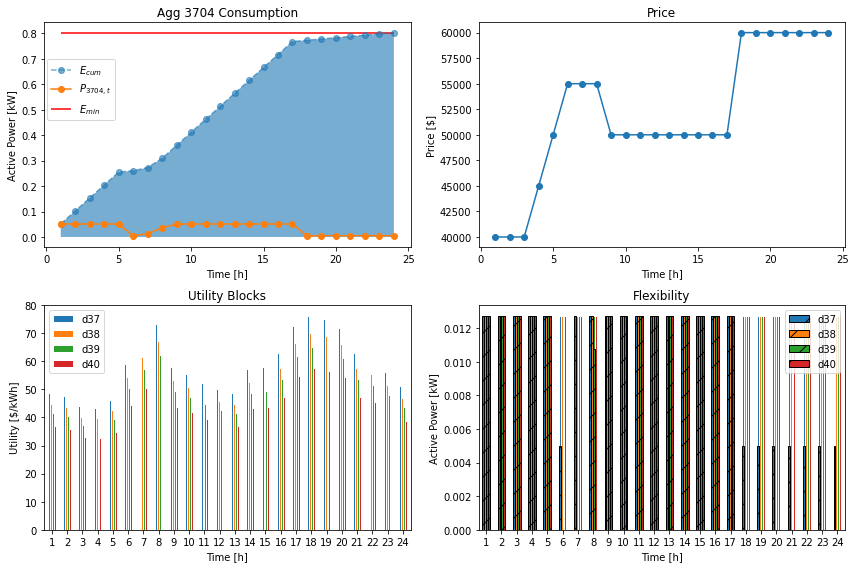

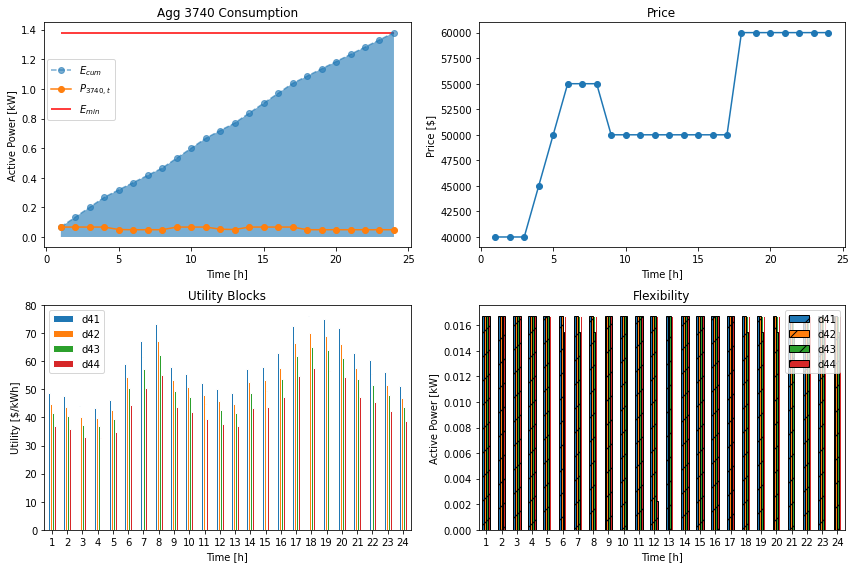

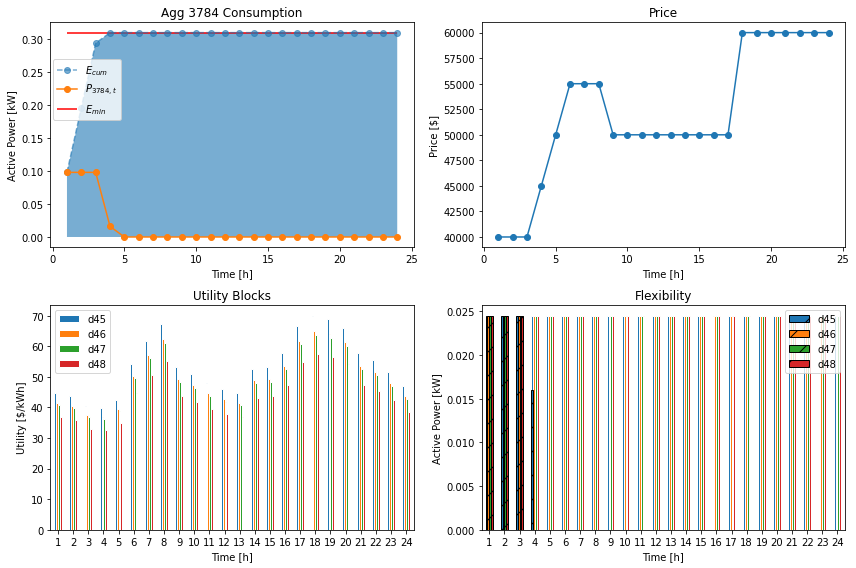

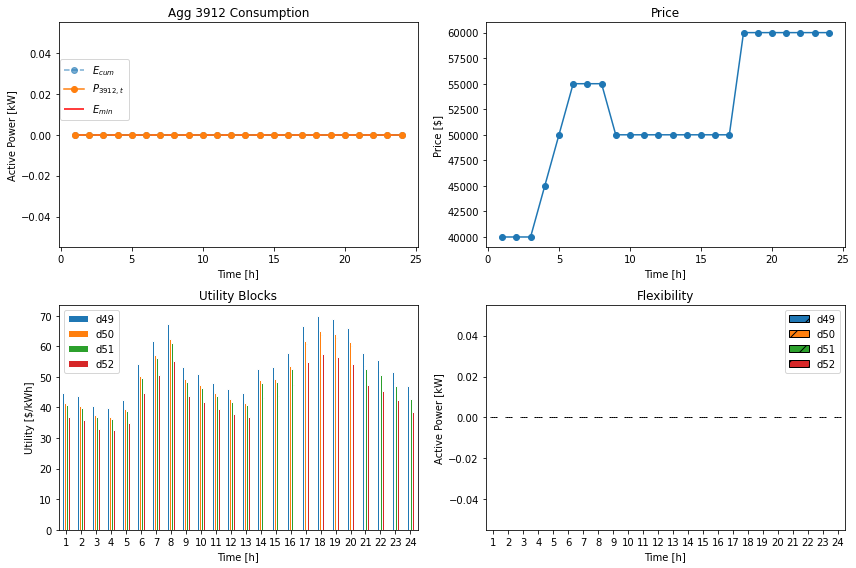

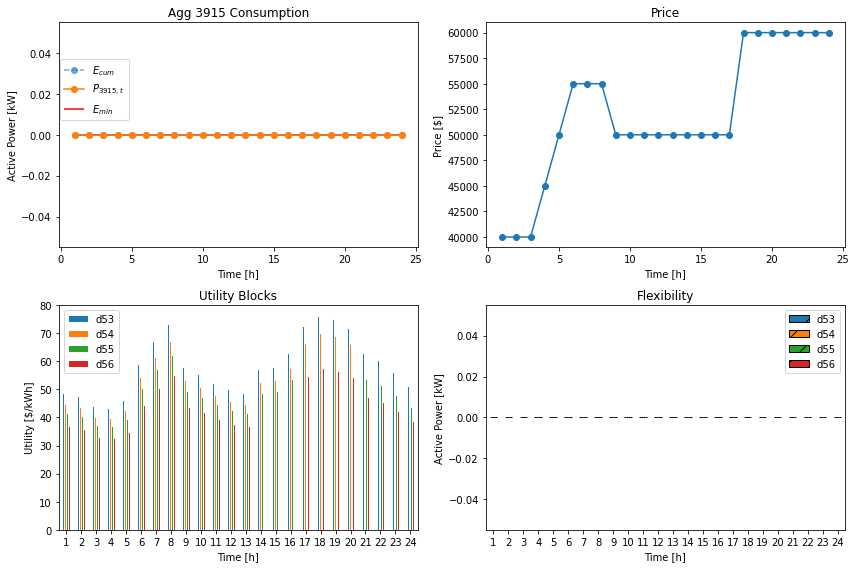

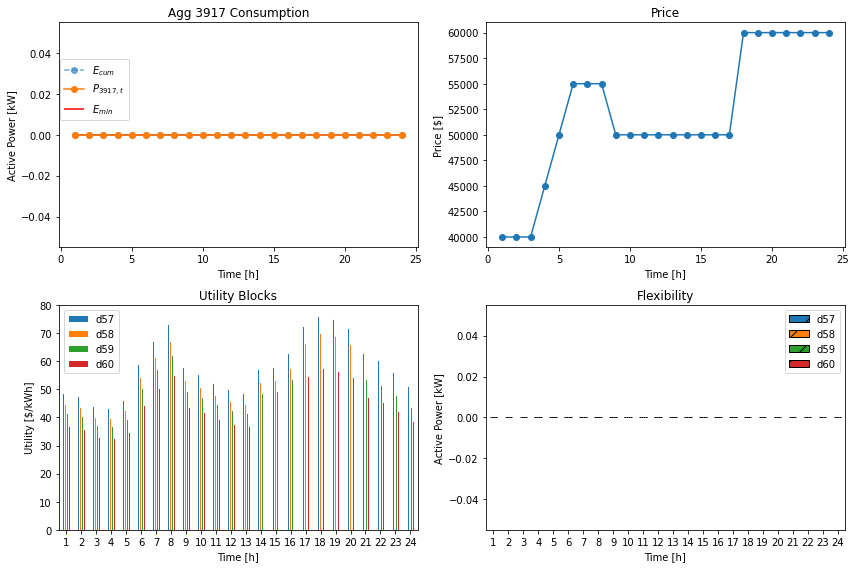

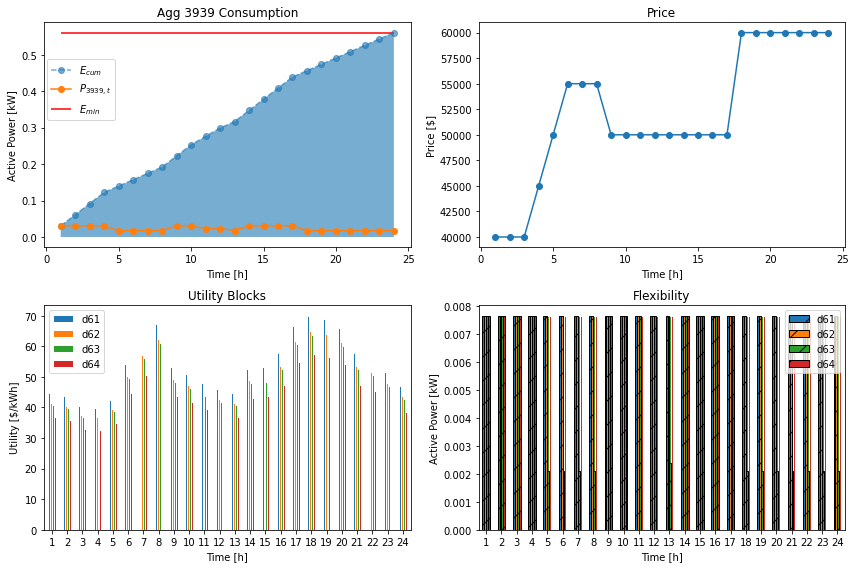

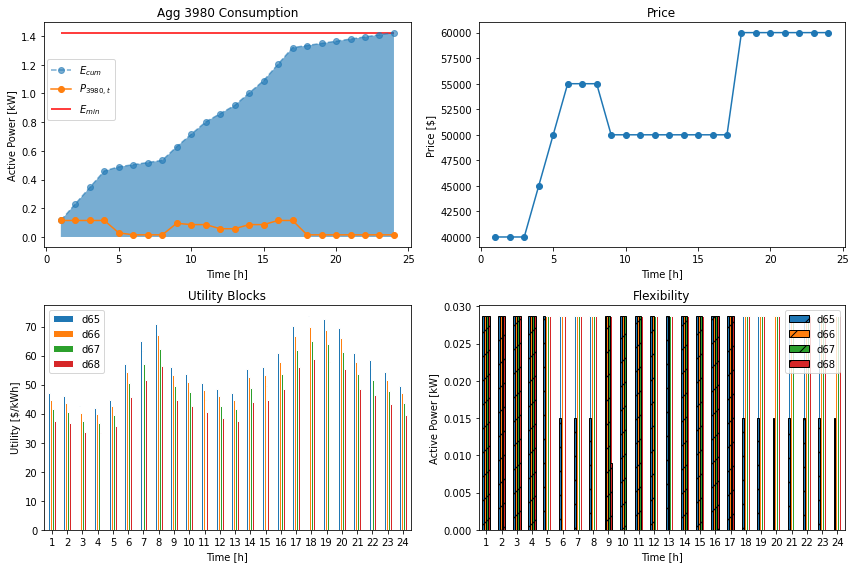

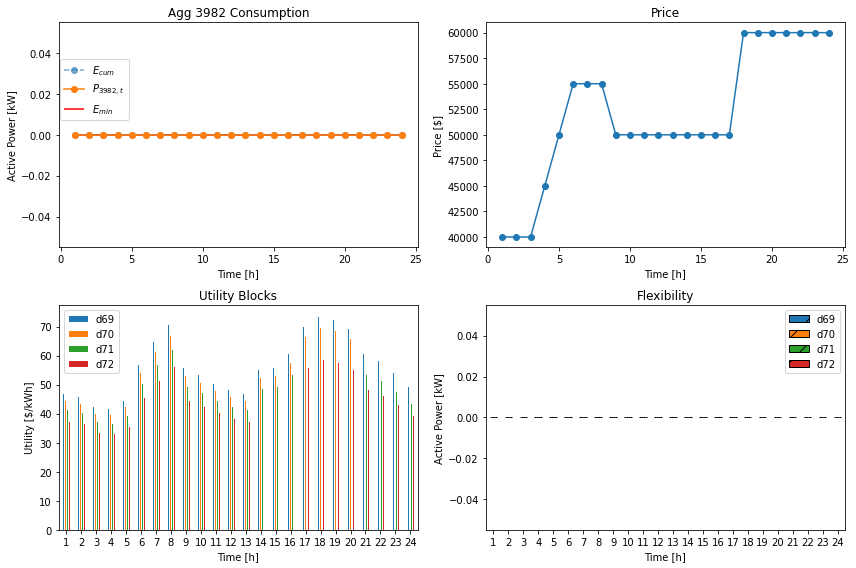

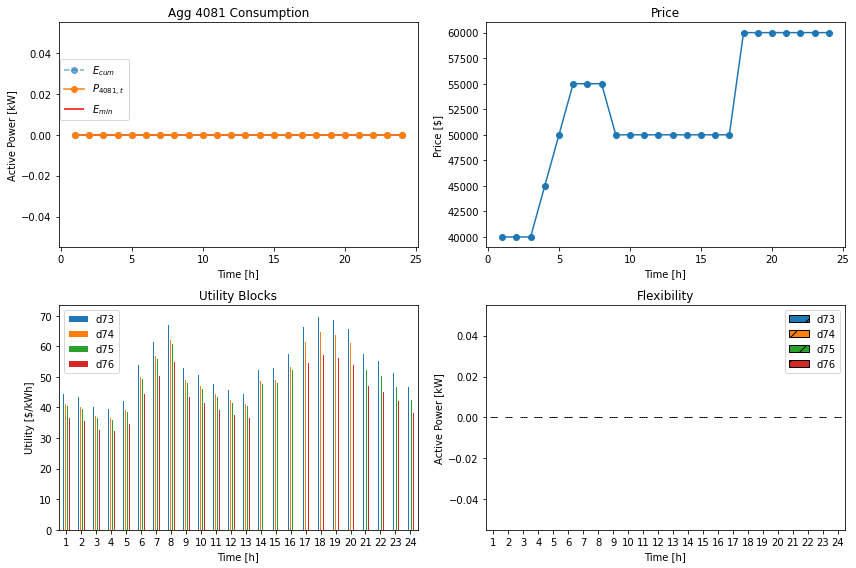

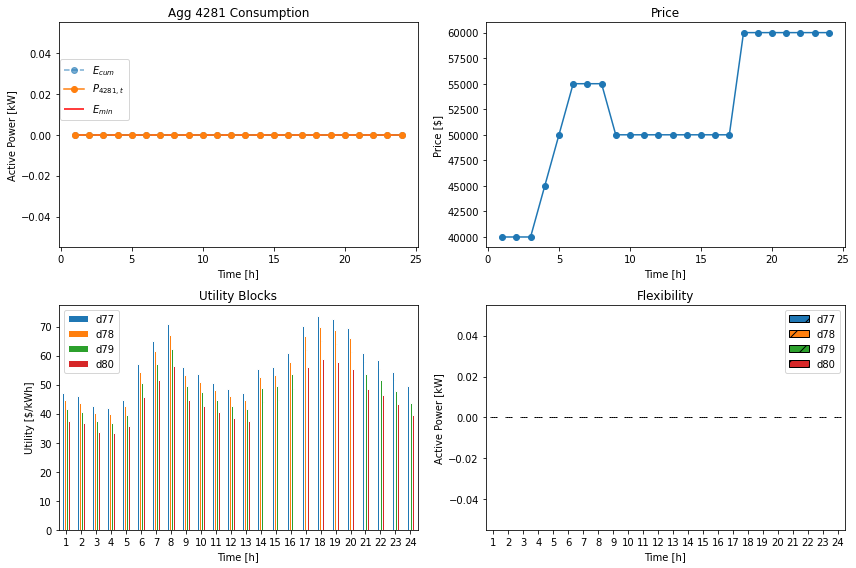

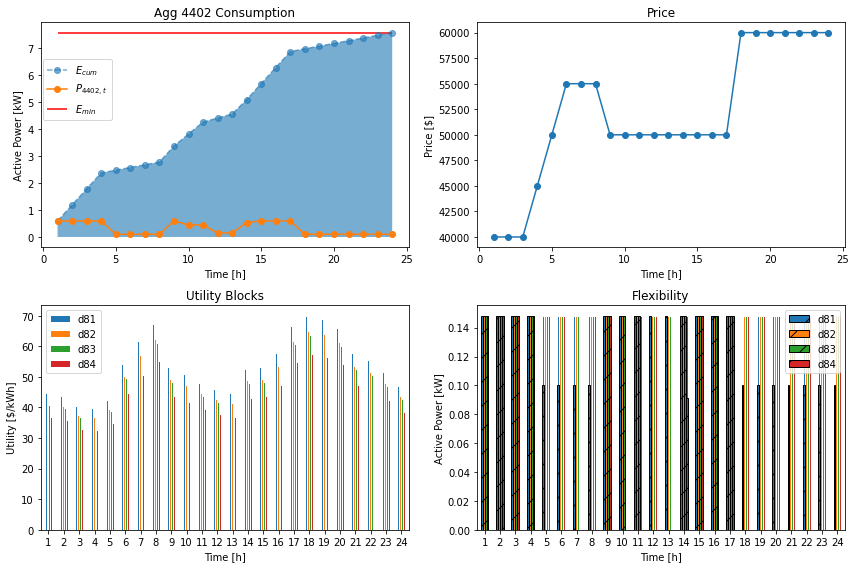

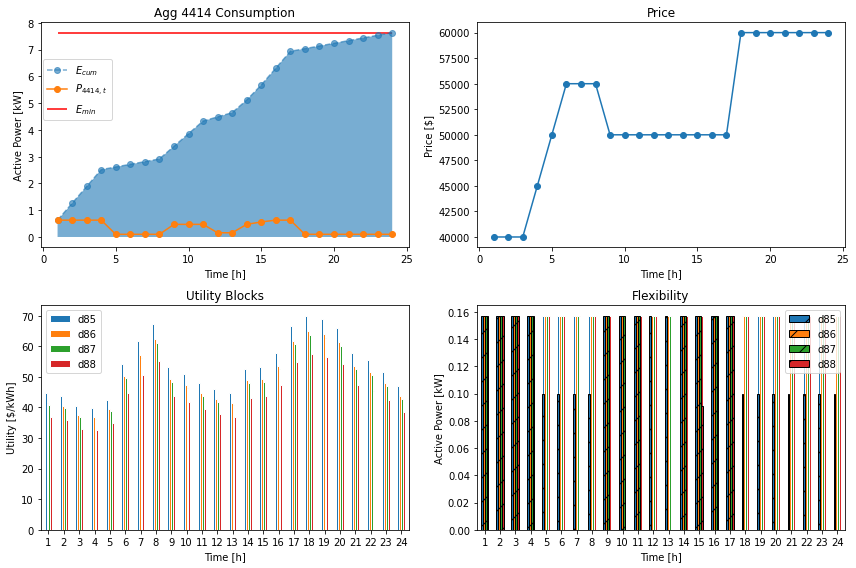

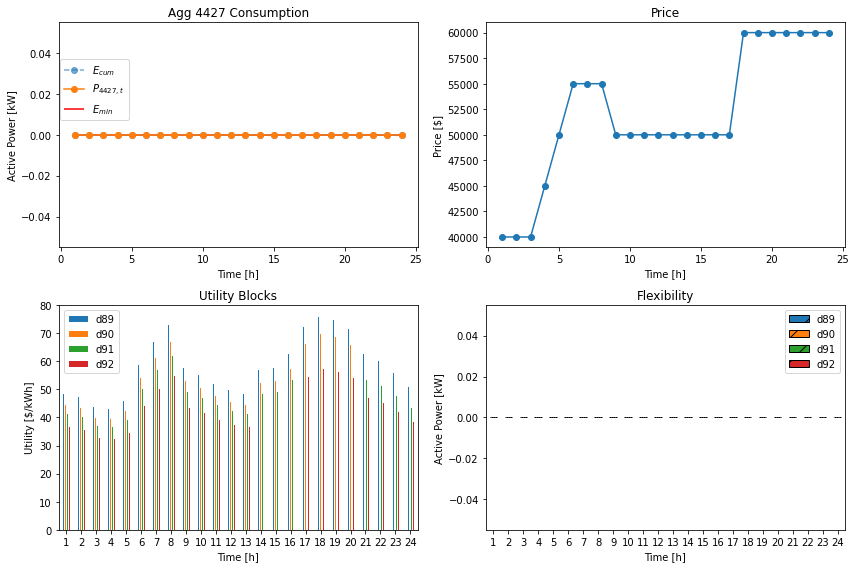

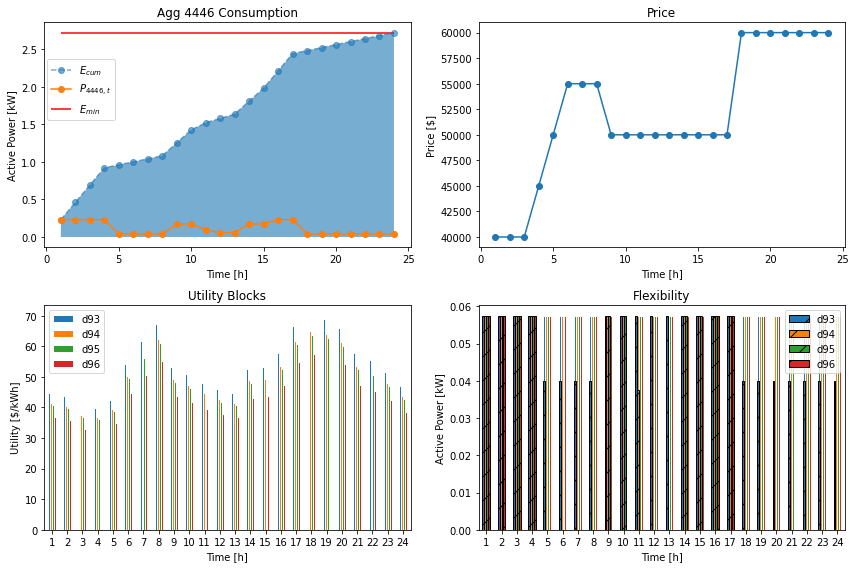

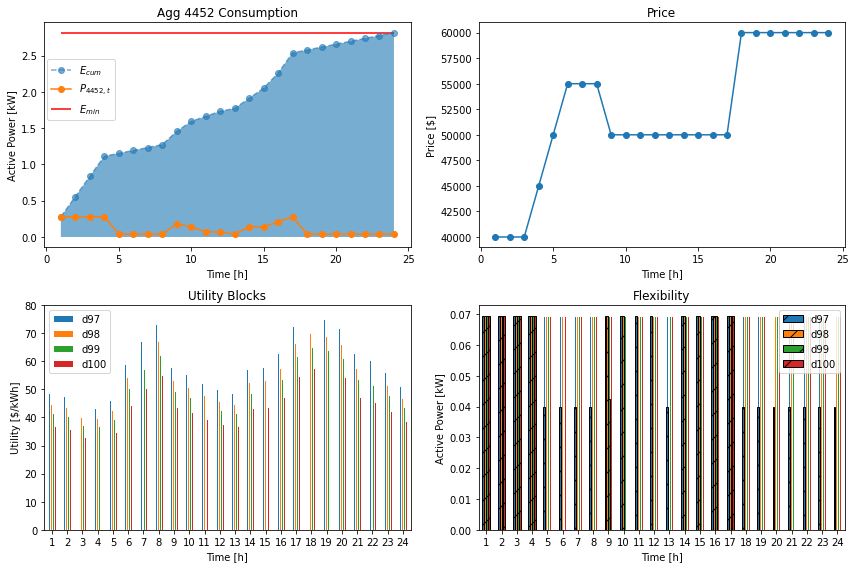

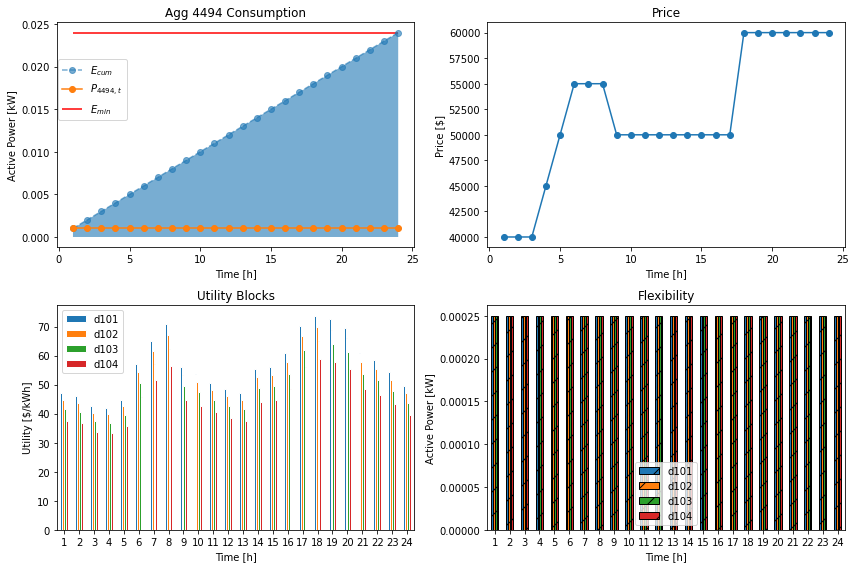

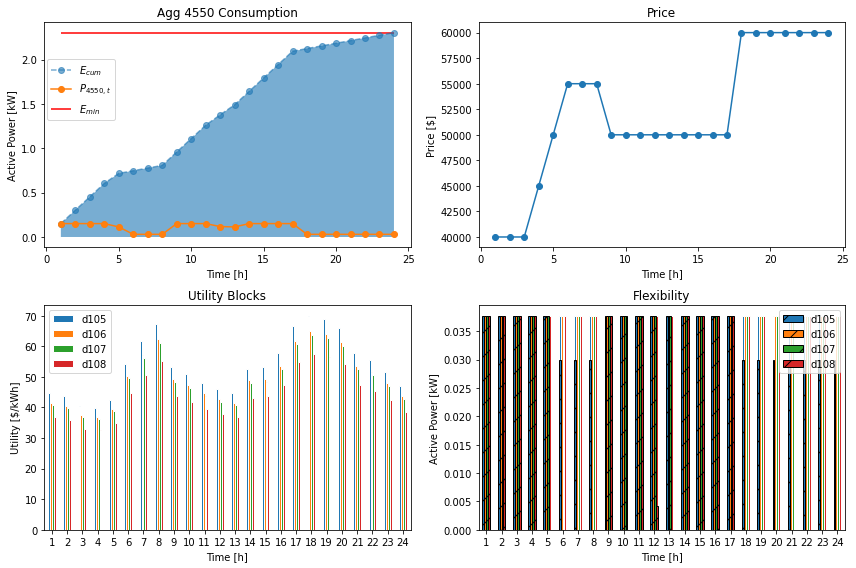

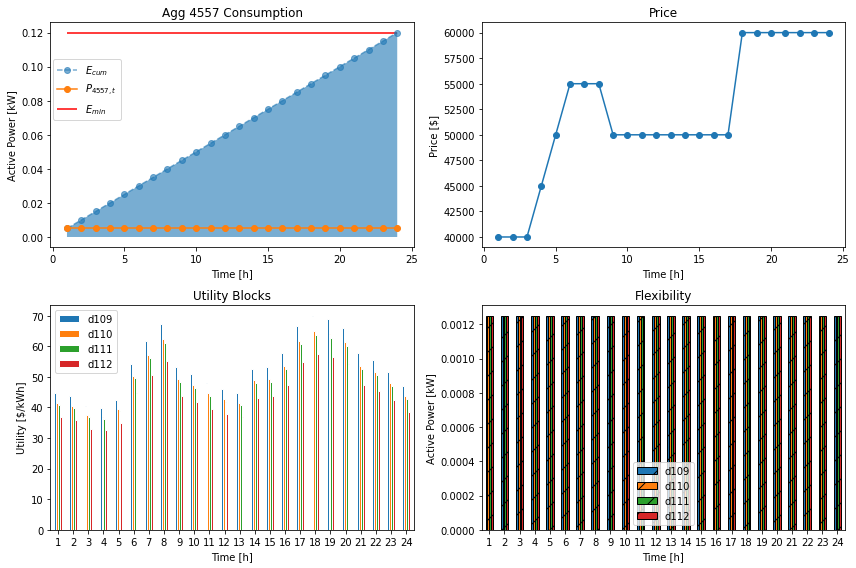

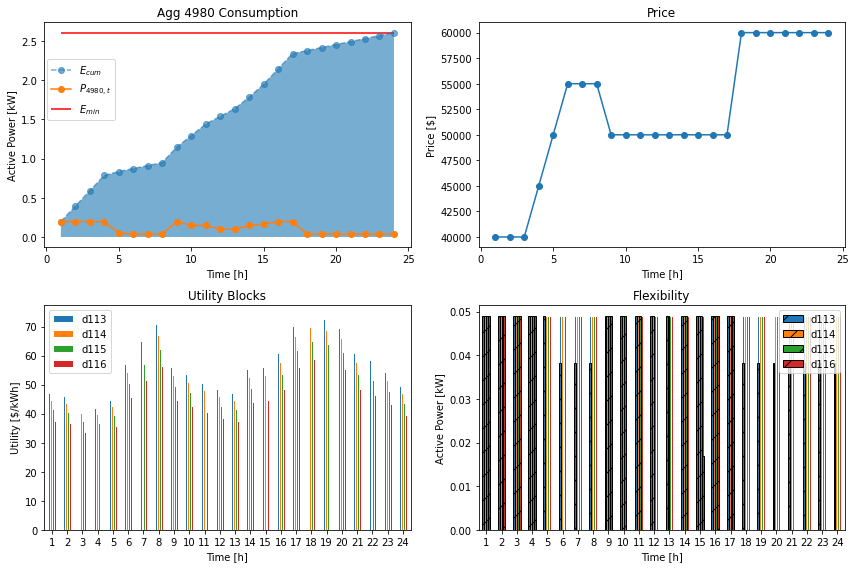

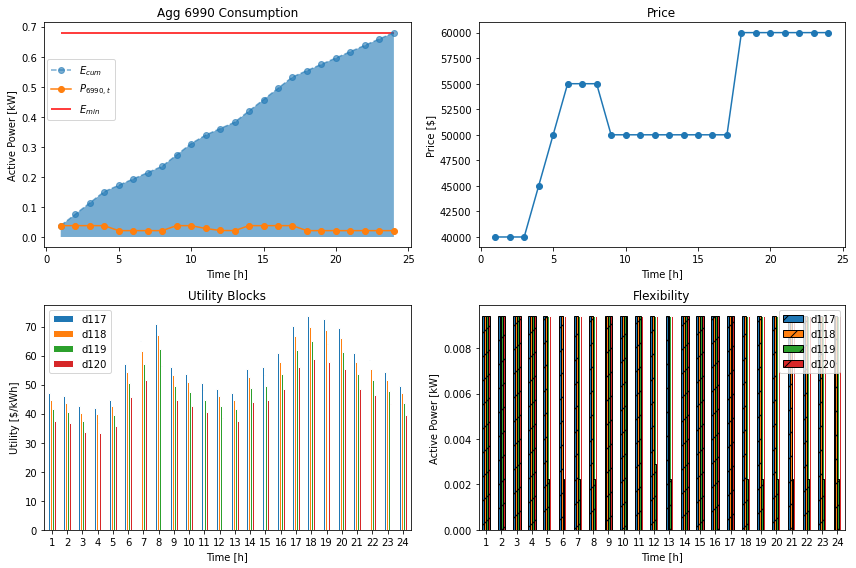

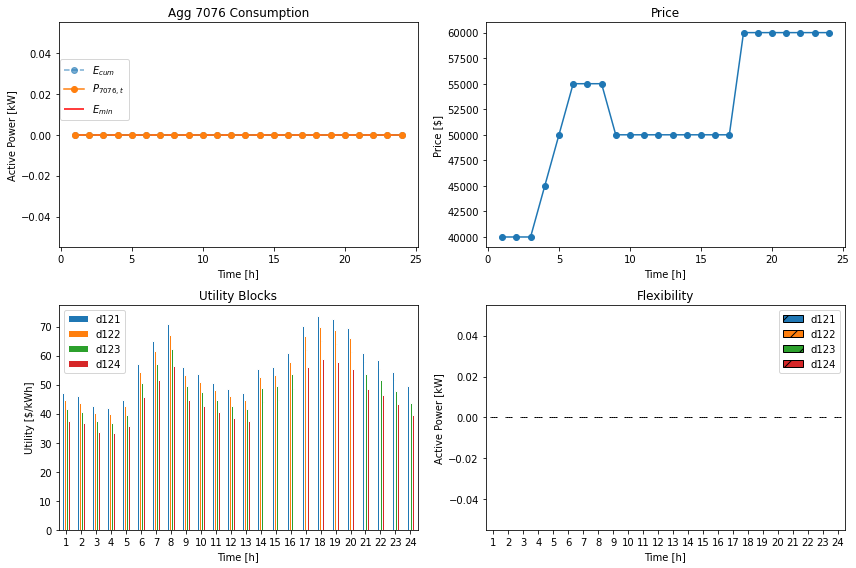

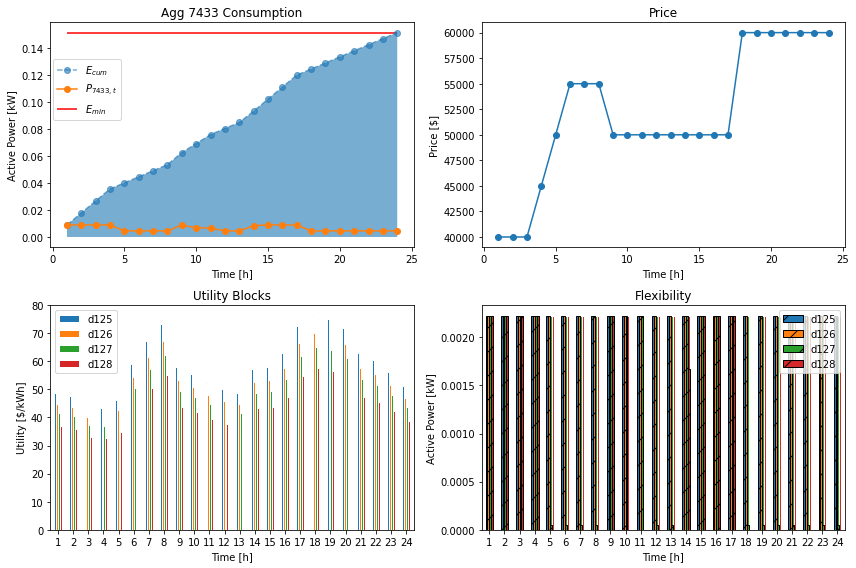

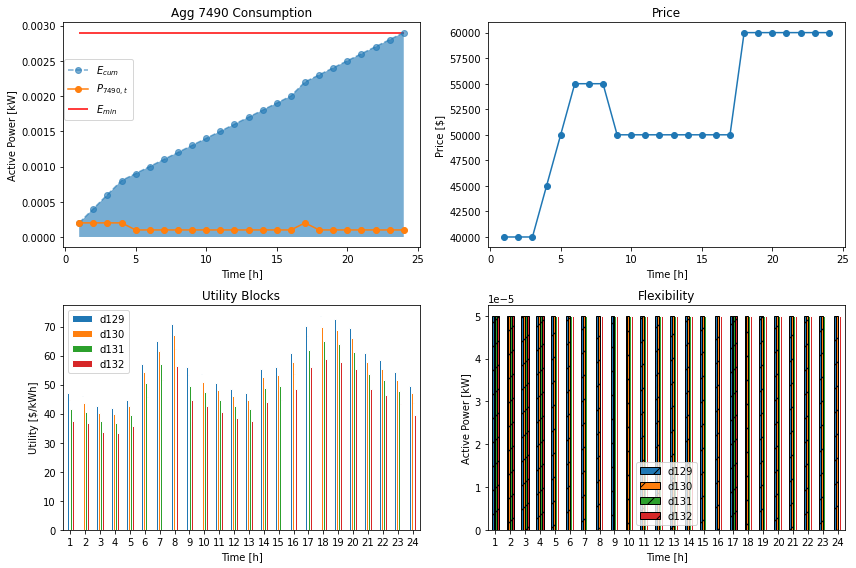

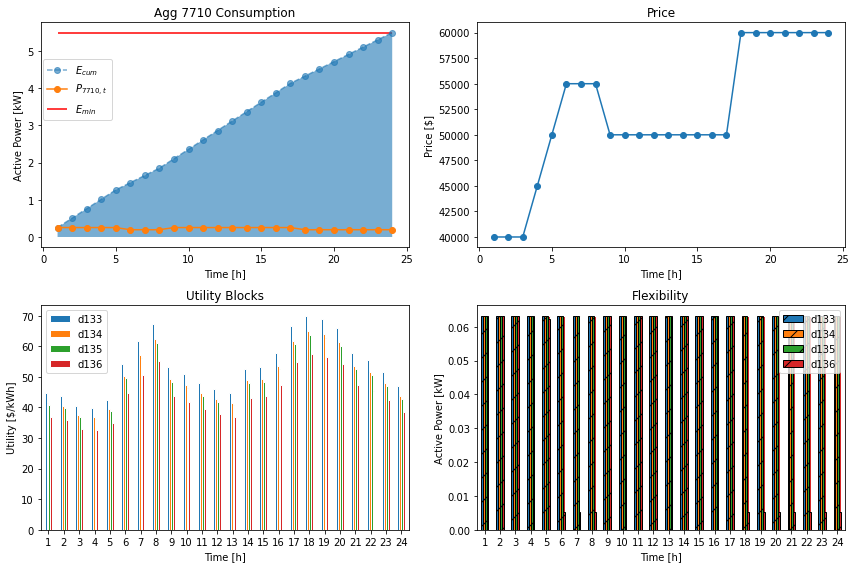

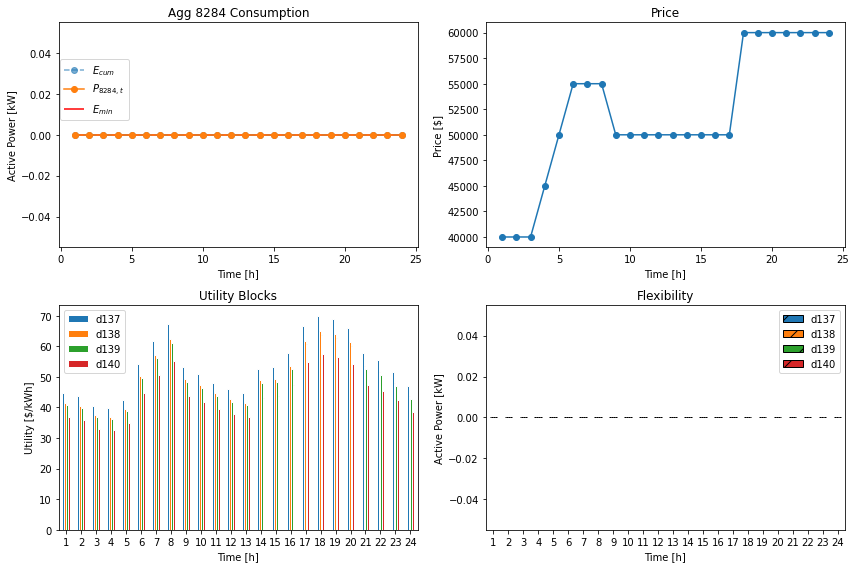

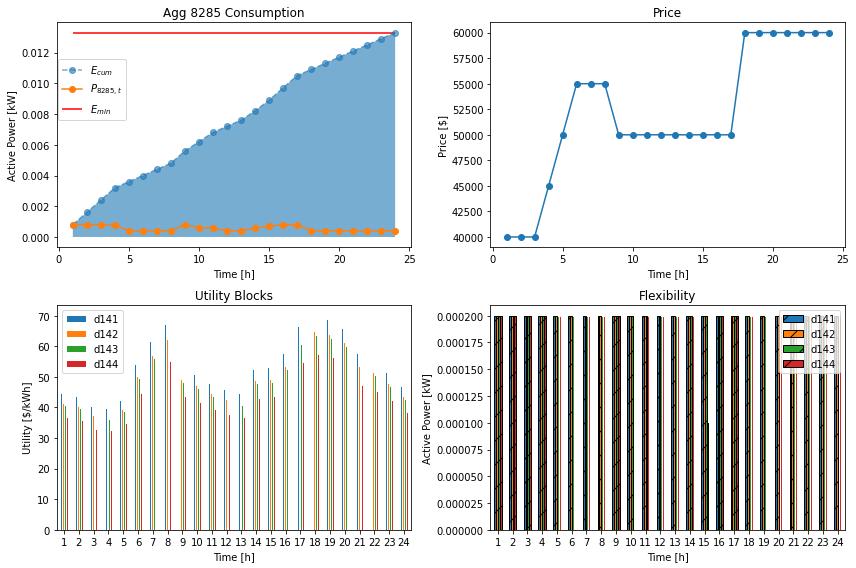

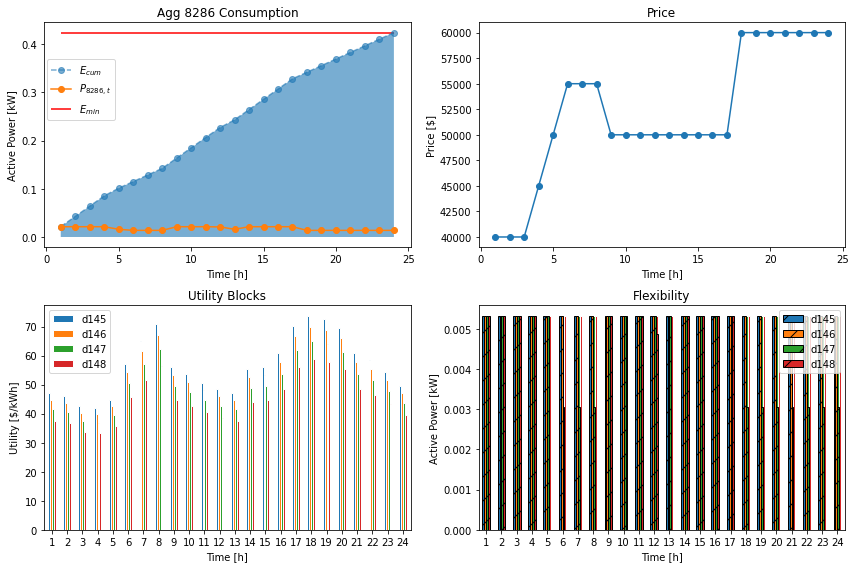

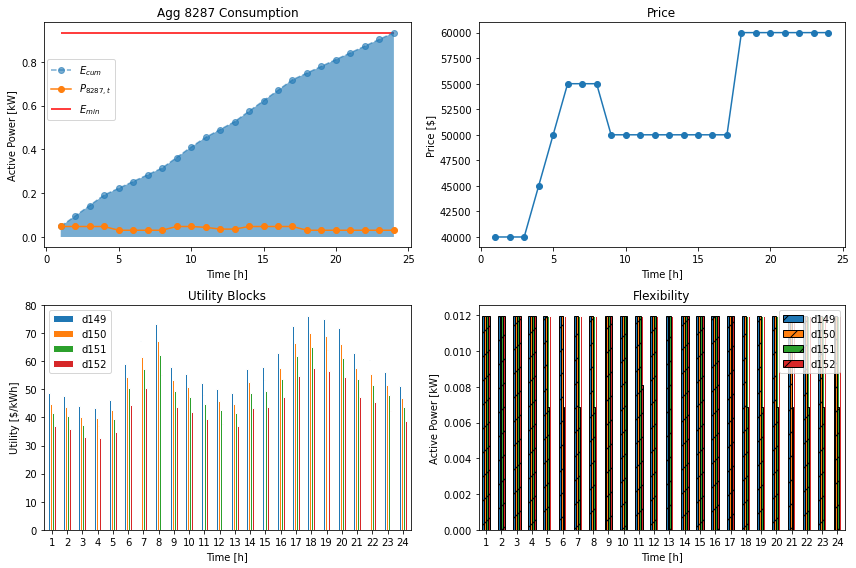

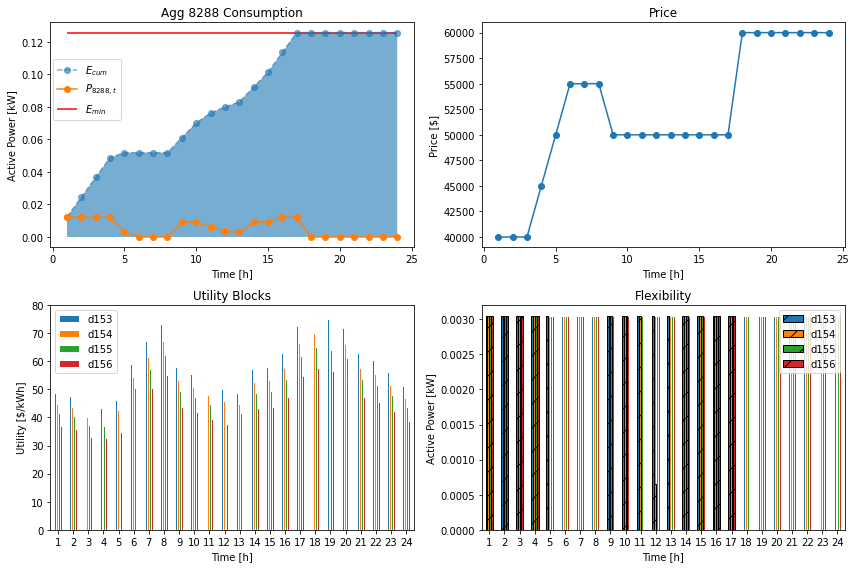

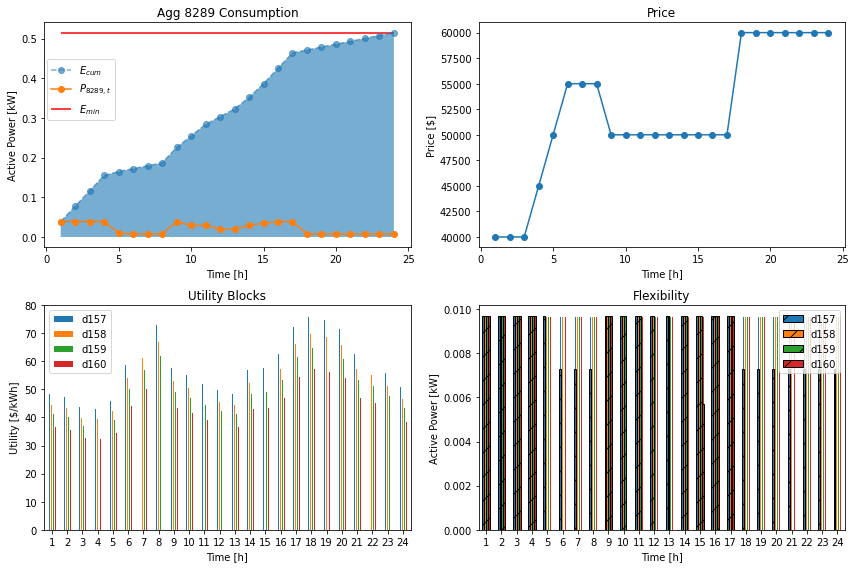

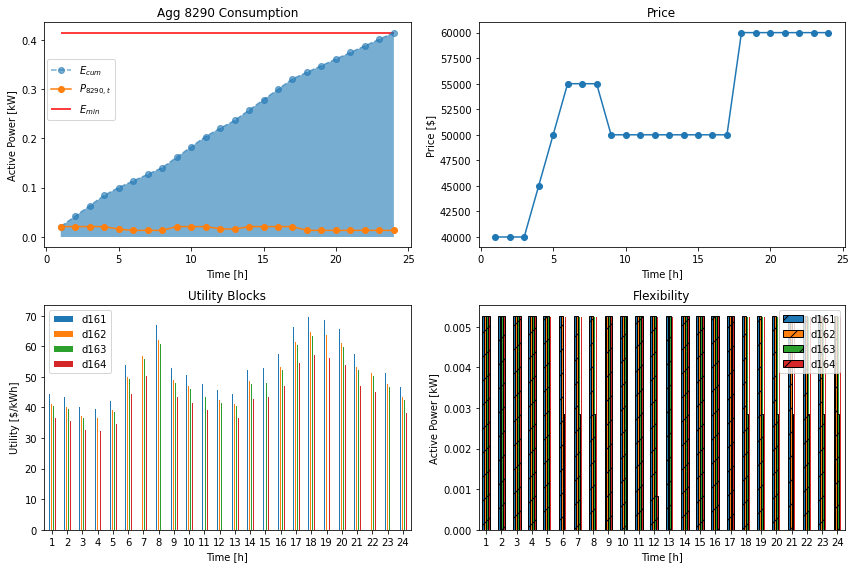

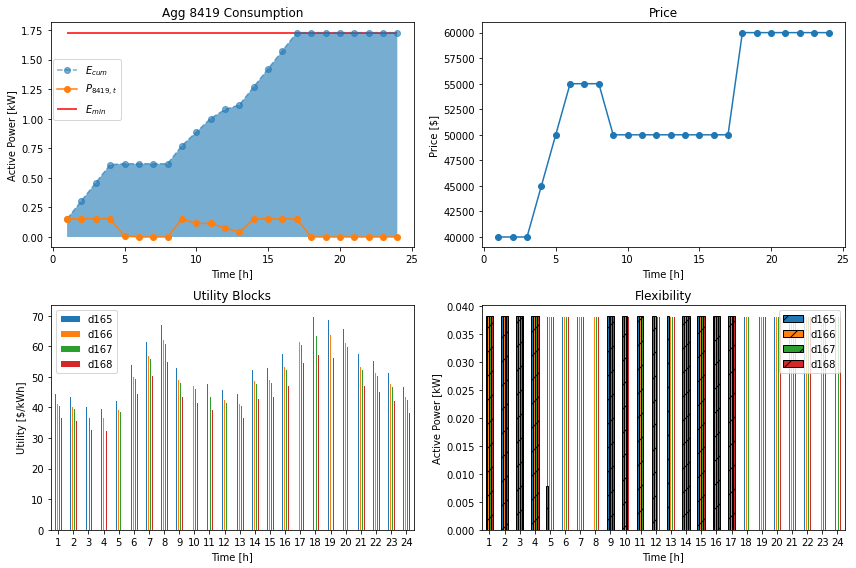

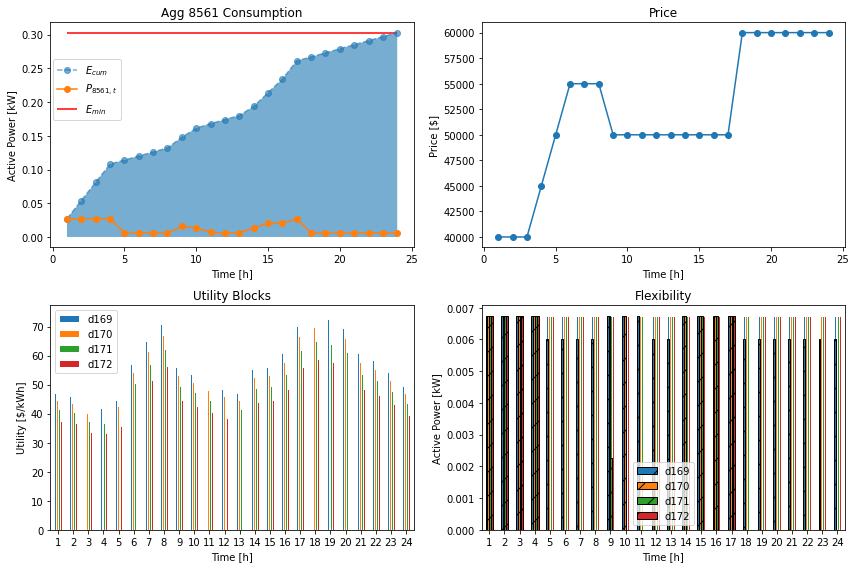

In [16]:
def follower_model(inputData, d_i):
    Sbase = 1000
    #---------------------------------------------------------------------------------------------------------
    #Inputs
    #---------------------------------------------------------------------------------------------------------
    NMd = 4     # number of demand blocks of DR aggregator
    AggData = inputData['AggData']
    DemandBlocks = inputData['DemandBlocks']
    UtilTimeMul = inputData['UtilTimeMul']
    SystemDemand = inputData['SystemDemand']
    NodeData = inputData['NodeData']

    aggs = [AggData.loc[i, 'AGG'] for i in AggData.index]
    dblocks = [DemandBlocks.loc[i, 'DB'] for i in DemandBlocks.index]
    time = [UtilTimeMul.loc[i, 'TIME'] for i in UtilTimeMul.index]
    utils = {(aggs[a], dblocks[d + NMd*a], time[t]) for a in AggData.index for d in range(NMd) for t in UtilTimeMul.index}  # $/MW

    RU = {aggs[i]:AggData.loc[i, 'RU']/Sbase for i in AggData.index}  # ramp up rate MW/h
    RD = {aggs[i]:AggData.loc[i, 'RD']/Sbase for i in AggData.index}  # ramp down rate MW/h

    MargUtil = {(aggs[a], dblocks[d + NMd*a], time[t]):UtilTimeMul.loc[t,'UtilMultiplier']*DemandBlocks.loc[DemandBlocks['AGG'] == \
               AggData.loc[a, 'AGG']]['MargUtil'].iloc[d]/1000*Sbase for a in AggData.index for d in range(NMd) for t in UtilTimeMul.index}  # $/MWh -> $/kWh -> $/pu

    Load = {(aggs[a], dblocks[d + NMd*a], time[t]):1000*max(SystemDemand.loc[:,aggs[a]])/NMd/Sbase for a in AggData.index for d in range(NMd) for t in UtilTimeMul.index}  # MW -> kW -> pu

    Energy = {a:1000*sum(SystemDemand.loc[t, a] for t in UtilTimeMul.index)/Sbase for a in aggs} # MWh -> kWh

    LoadMin = {(aggs[a], time[t]):1000*min(SystemDemand.loc[:,aggs[a]])/Sbase for a in AggData.index  for t in UtilTimeMul.index}  # kW -> pu

    Pdini = {a:1000*min(SystemDemand.loc[:,a])/Sbase for a in aggs} # MW -> kW -> pu

    Price = {time[t]:UtilTimeMul.loc[t, 'Price']*Sbase for t in UtilTimeMul.index}  # $

    #---------------------------------------------------------------------------------------------------------
    #Define the Model
    #---------------------------------------------------------------------------------------------------------

    fmodel = ConcreteModel()

    #---------------------------------------------------------------------------------------------------------
    #Define Sets
    #---------------------------------------------------------------------------------------------------------

    fmodel.AGG = Set(initialize=aggs)
    fmodel.BLOCK = Set(initialize=dblocks)
    fmodel.TIME = Set(initialize=time, ordered=True)
    fmodel.UTILS = Set(initialize=utils, ordered=False)

    #---------------------------------------------------------------------------------------------------------
    #Define Parameters
    #---------------------------------------------------------------------------------------------------------

    fmodel.ct = Param(fmodel.TIME, initialize=Price, mutable=True, within=NonNegativeReals)
    fmodel.RD = Param(fmodel.AGG, initialize=RD, mutable=True, within=NonPositiveReals)
    fmodel.RU = Param(fmodel.AGG, initialize=RU, mutable=True, within=NonNegativeReals)
    fmodel.util = Param(fmodel.UTILS, mutable=True, initialize=MargUtil, within=NonNegativeReals)
    fmodel.PblockMax = Param(fmodel.UTILS, mutable=True, initialize=Load, within=NonNegativeReals)
    fmodel.AGG_LoadMin = Param(fmodel.AGG, fmodel.TIME, mutable=True, initialize=LoadMin, within=NonNegativeReals)
    fmodel.AGG_Pdini = Param(fmodel.AGG, initialize=Pdini, mutable=True, within=Any)


    fmodel.Etot = Param(fmodel.AGG, initialize=Energy, mutable=True, within=NonNegativeReals)
    def inflexible_energy(fmodel, a):
        return fmodel.Etot[a]
    fmodel.Einflex = Param(fmodel.AGG, rule=inflexible_energy)

    #---------------------------------------------------------------------------------------------------------
    #Define Variables
    #---------------------------------------------------------------------------------------------------------

    fmodel.Pdt = Var(fmodel.AGG, fmodel.TIME, within=NonNegativeReals, initialize=0)
    fmodel.Pdmt = Var(fmodel.UTILS, within=NonNegativeReals, initialize=0)

    #---------------------------------------------------------------------------------------------------------
    #Define Objective
    #---------------------------------------------------------------------------------------------------------

    def follower_obj(fmodel):
        return sum(fmodel.ct[t]*fmodel.Pdt[d_i,t] for t in fmodel.TIME) - \
               sum(fmodel.util[d,m,t]*fmodel.Pdmt[d,m,t] for d,m,t in fmodel.UTILS if d == d_i)
    fmodel.fobj = Objective(rule=follower_obj)
    #---------------------------------------------------------------------------------------------------------
    #Define Constraints
    #---------------------------------------------------------------------------------------------------------

    def aggregated_load_rule(fmodel, t_i):
        return fmodel.Pdt[d_i,t_i] == sum(fmodel.Pdmt[d,m,t] for d,m,t in fmodel.UTILS if d == d_i and t == t_i)
    fmodel.aggregated_load = Constraint(fmodel.TIME, rule=aggregated_load_rule)

    def max_block_size_rule(fmodel, d, m, t):
        if d == d_i:
            return inequality(0, fmodel.Pdmt[d,m,t], fmodel.PblockMax[d,m,t])
        else:
            return Constraint.Skip
    fmodel.max_block_size = Constraint(fmodel.UTILS, rule=max_block_size_rule)

    def total_energy_rule(fmodel):
        return sum(fmodel.Pdt[d_i,t] for t in fmodel.TIME) >= fmodel.Einflex[d_i]
    fmodel.total_energy = Constraint(rule=total_energy_rule)

    def agg_ramp_rule(fmodel, t):
        if fmodel.TIME.ord(t) == 1:
            # for testing purposes initialize initial consumption to 1 MW
            return inequality(fmodel.RD[d_i], fmodel.Pdt[d_i,t] - fmodel.AGG_Pdini[d_i], fmodel.RU[d_i])
        elif fmodel.TIME.ord(t) > 1:
            return inequality(fmodel.RD[d_i], fmodel.Pdt[d_i,t] - fmodel.Pdt[d_i,fmodel.TIME.prev(t)], fmodel.RU[d_i])
    fmodel.agg_ramp = Constraint(fmodel.TIME, rule=agg_ramp_rule)

    def agg_min_consumption_rule(model, t):
            return model.AGG_LoadMin[d_i,t] - model.Pdt[d_i,t] <= 0
    fmodel.agg_min_consumption = Constraint(fmodel.TIME, rule=agg_min_consumption_rule)

    return fmodel

results = dict.fromkeys(data['AggData']['AGG'].tolist())
solver = SolverFactory('gurobi')
# define and solve the problem for each aggregator
for agg in results:
    fmodel = follower_model(data, d_i=agg)
    #fmodel.pprint()
    result = solver.solve(fmodel)#, tee=True)
    results[agg] = result
    data_viz(fmodel, d_i=agg)

In [17]:
print(results)

{2035: {'Problem': [{'Name': 'x5161', 'Lower bound': 3411.353735, 'Upper bound': 3411.353735, 'Number of objectives': 1, 'Number of constraints': 290, 'Number of variables': 121, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 121, 'Number of nonzeros': 455, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.004924774169921875', 'Error rc': 0, 'Time': 0.1100914478302002}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}, 2036: {'Problem': [{'Name': 'x5161', 'Lower bound': 16501.80255050001, 'Upper bound': 16501.80255050001, 'Number of objectives': 1, 'Number of constraints': 290, 'Number of va